# Santander Transaction Customer Prediction
## Matthew Przybyla
### ScaleFactor Interview

## Theoretical Questions

Questions:

"I want to be able to predict which type of customer will purchase a certain product in the future?"
1. What are some key pieces of information you would like to have to predict this?
2. How would you like the data structured?
3. What are some follow-up questions you would like to ask the business user?

Solutions:

1. Some key pieces of information I would like to have to predict this would be: data location/storage (i.e, Microsoft SQL Server), updated regularly/on a schedule or not, data type (continuous, binary, or categorical, as well as if it's a string, object, or int).


2. I would like the data structured in a tabular format such that there are clearly labeled columns with their associated record values, derived from a CSV file/queried from a SQL/Hive database. From there I would read in the CSV file to a pandas dataframe so it could be used by various machine learning libraries (i.e., sklearn, TensorFlow, and Keras). A dataframe helps to dissect that data itself as well (i.e., identifying NaN's). It would also be useful to be able to run PySpark - Apache Spark from a SQL/Hive interface to draw more efficient machine learning results directly. 


3. Has someone else worked on this data before (to eliminate duplicate efforts and learn from previous worker)? Can you more clearly define the future (i.e, weeks, months)? Do you have an expectation for who would make a certain purchase? How do you think this will affect the business? Is this something that is static and applied to a one-time dataset, or does it need to be automated and connected to a live datawarehouse source? 

# 1.

# A. EDA/Preprocessing

#### Import Initial Libraries

In [1]:
import datetime
import numpy as np
import pandas as pd
#from sklearn import cross_validation
from sklearn.model_selection import cross_validate
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc
import gc
#import matplotlib.pyplot as plt
#import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

###### Import the Dataset from:
https://www.kaggle.com/c/santander-customer-transaction-prediction

In [2]:
test = pd.read_csv("C:\\Users\\mprzybyla\\Downloads\\santander-customer-transaction-prediction\\test.csv")
train = pd.read_csv("C:\\Users\\mprzybyla\\Downloads\\santander-customer-transaction-prediction\\train.csv")

In [3]:
#Let's see how this data looks!
train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [4]:
train.shape

(200000, 202)

In [5]:
test.shape

(200000, 201)

Check for missing values

In [6]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns

In [7]:
missing_values_table(train)

Your selected dataframe has 202 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


See how many of the train set is the target

In [8]:
train.groupby('target').size()

target
0    179902
1     20098
dtype: int64

Balance check and upsamplings to account for underepresentation of the model

In [9]:
# Separate majority and minority classes
df_majority = train[train.target==0]
df_minority = train[train.target==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=179902,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.target.value_counts()

1    179902
0    179902
Name: target, dtype: int64

# B. Feature Engineering/ Feature Selection

The target variable will be y and the rest of the variables will be X

In [10]:
y = df_upsampled['target']
y_df = pd.DataFrame(y)

In [11]:
X = df_upsampled.drop(columns=['target'])

In [12]:
X = X.drop(columns=['ID_code'])

In [13]:
X.shape

(359804, 200)

In [14]:
y_df.shape

(359804, 1)

In [15]:
X.dtypes.head()

var_0    float64
var_1    float64
var_2    float64
var_3    float64
var_4    float64
dtype: object

#### Variable Importance using Random Forest

In [16]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()

clf.fit(X,y_df)

preds = clf.predict(X)

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(preds,y_df)
print(accuracy)

0.9999833242543162


In [17]:
VI = DataFrame(clf.feature_importances_, columns = ["RF"], index=X.columns)

In [18]:
VI = VI.reset_index()
VI.sort_values(['RF'],ascending=0)

,index,RF
139,var_139,0.017331
81,var_81,0.016609
26,var_26,0.012650
12,var_12,0.011646
53,var_53,0.011127
110,var_110,0.011045
6,var_6,0.010408
174,var_174,0.010348
146,var_146,0.010092
22,var_22,0.009258


#### Recursive Feature Elimination

In [20]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
rfe = RFE(model, 20)
#fit = rfe.fit(X, y_df)

In [ ]:
Selected = DataFrame(rfe.support_, columns = ["RFE"], index=X.columns)
Selected = Selected.reset_index()

In [ ]:
Selected[Selected['RFE'] == True]

#### Variable Importance using Extratrees Classifier

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier()
model.fit(X, y_df)

print(model.feature_importances_)

In [ ]:
FI = DataFrame(model.feature_importances_, columns = ["Extratrees"], index=X.columns)

In [ ]:
FI = FI.reset_index()

In [ ]:
FI.sort_values(['Extratrees'],ascending=0)

#### L1 Feature Selection

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X, y_df)
model = SelectFromModel(lsvc,prefit=True)

In [ ]:
l1 = DataFrame(model.get_support(), columns = ["L1"], index=X.columns)
l1 = l1.reset_index()

In [ ]:
l1[l1['L1'] == True]

In [ ]:
from functools import reduce
dfs = [VI]
final_results = reduce(lambda left,right: pd.merge(left,right,on='index'), dfs)

Rank features based off of the four different methods.

In [ ]:
columns = ['RF', 'RFE', 'Extratrees', 'L1']

score_table = pd.DataFrame({},[])
score_table['index'] = final_results['index']

for i in columns:
    score_table[i] = final_results['index'].isin(list(final_results.nlargest(5,i)['index'])).astype(int)
    
#score_table['RFE'] = final_results['RFE'].astype(int)
#score_table['L1'] = final_results['L1'].astype(int)

In [ ]:
score_table['final_score'] = score_table.sum(axis=1)

In [ ]:
score_table.sort_values('final_score',ascending=0)

In [28]:
def calculate_vif(X):
    vif = pd.DataFrame()
    vif["Features"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]    
    return(vif)

In [29]:
X = X[list(score_table[score_table['final_score'] >= 1]['index'])]

In [30]:
vif = calculate_vif(X)
while vif['VIF'][vif['VIF'] > 10].any():
    remove = vif.sort_values('VIF',ascending=0)['Features'][:1]
    X.drop(remove,axis=1,inplace=True)
    vif = calculate_vif(X)

Keep only the important features that won't contribute to overfitting - that are taughtological

In [31]:
list(vif['Features'])

['var_26', 'var_81', 'var_110', 'var_139']

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_df, test_size=0.20)
                                                    #, 
                                                    #random_state=101)

# C. Base Algorithm Choice and Reason for Selection

The base algorithm was a random forest classifier because it often times works well with binary classification,


and is more accurate as well as more robust than a decision tree - more accurate than a simple logistic regression.

In [42]:
X_train, X_test, y_df_train, y_df_test = train_test_split(X,y_df, test_size = 0.4)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

features_train = train[list(vif['Features'])]
label_train = y_df['target']
features_test = test[list(vif['Features'])]
label_test = y_df['target']

In [43]:
X_train.shape

(215882, 4)

In [44]:
y_train.shape

(287843, 1)

In [45]:
X_test.shape

(143922, 4)

In [46]:
y_test.shape

(71961, 1)

In [49]:
X_train = features_train
X_test = features_test
y_train = label_train
y_test = label_test

In [ ]:
#from sklearn.ensemble import RandomForestClassifier
#clf = RandomForestClassifier(**rf_random.best_params_)

#clf.fit(features_train,label_train)

#pred_train = clf.predict(features_train)
#pred_test = clf.predict(features_test)

#from sklearn.metrics import accuracy_score
#accuracy_train = accuracy_score(pred_train,label_train)
#accuracy_test = accuracy_score(pred_test,label_test)

#from sklearn import metrics
#fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
#auc_train = metrics.auc(fpr,tpr)

#fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
#auc_test = metrics.auc(fpr,tpr)

#print(accuracy_train,accuracy_test,auc_train,auc_test)

In [ ]:
#from sklearn.model_selection import RandomizedSearchCV
#from sklearn.ensemble import RandomForestClassifier

#n_estimators = [int(x) for x in np.linspace(start = 10, stop = 500, num = 10)]
#max_features = ['auto', 'sqrt']
#max_depth = [int(x) for x in np.linspace(3, 10, num = 1)]
#max_depth.append(None)
#min_samples_split = [2, 5, 10]
#min_samples_leaf = [1, 2, 4]
#bootstrap = [True, False]

#random_grid = {'n_estimators': n_estimators,
#               'max_features': max_features,
#               'max_depth': max_depth,
#               'min_samples_split': min_samples_split,
#               'min_samples_leaf': min_samples_leaf,
#               'bootstrap': bootstrap}

#rf = RandomForestClassifier()

#rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
#rf_random.fit(features_train, label_train)

#print(rf_random.best_params_)

In [75]:
param = {
    'num_leaves': 18,
     'max_bin': 63,
     'min_data_in_leaf': 5,
     'learning_rate': 0.010614430970330217,
     'min_sum_hessian_in_leaf': 0.0093586657313989123,
     'feature_fraction': 0.056701788569420042,
     'lambda_l1': 0.060222413158420585,
     'lambda_l2': 4.6580550589317573,
     'min_gain_to_split': 0.29588543202055562,
     'max_depth': 49,
     'save_binary': True,
     'seed': 1337,
     'feature_fraction_seed': 1337,
     'bagging_seed': 1337,
     'drop_seed': 1337,
     'data_random_seed': 1337,
     'objective': 'binary',
     'boosting_type': 'gbdt',
     'verbose': 1,
     'metric': 'auc',
     'is_unbalance': True,
     'boost_from_average': False
}

In [76]:
nfold = 10

In [77]:
target = 'target'
predictors = train.columns.values.tolist()[2:]

In [79]:
gc.collect()

527

# D. Final Algorithm Choice

In [102]:
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from sklearn import metrics

In [ ]:
train_df = df_upsampled
test_df = test

In [103]:
skf = StratifiedKFold(n_splits=nfold, shuffle=True, random_state=2019)

oof = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))

i = 1
for train_index, valid_index in skf.split(train_df, train_df.target.values):
    print("\nfold {}".format(i))
    xg_train = lgb.Dataset(train_df.iloc[train_index][predictors].values,
                           label=train_df.iloc[train_index][target].values,
                           feature_name=predictors,
                           free_raw_data = False
                           )
    xg_valid = lgb.Dataset(train_df.iloc[valid_index][predictors].values,
                           label=train_df.iloc[valid_index][target].values,
                           feature_name=predictors,
                           free_raw_data = False
                           )   

    nround = 8523
    clf = lgb.train(param, xg_train, nround, valid_sets = [xg_valid], verbose_eval=250)
    oof[valid_index] = clf.predict(train_df.iloc[valid_index][predictors].values, num_iteration=nround) 
    
    predictions += clf.predict(test_df[predictors], num_iteration=nround) / nfold
    i = i + 1

print("\n\nCV AUC: {:<0.4f}".format(metrics.roc_auc_score(train_df.target.values, oof)))


fold 1
[250]	valid_0's auc: 0.882545
[500]	valid_0's auc: 0.890916
[750]	valid_0's auc: 0.896247
[1000]	valid_0's auc: 0.899833
[1250]	valid_0's auc: 0.903193
[1500]	valid_0's auc: 0.906068
[1750]	valid_0's auc: 0.908837
[2000]	valid_0's auc: 0.911362
[2250]	valid_0's auc: 0.913906
[2500]	valid_0's auc: 0.916285
[2750]	valid_0's auc: 0.918456
[3000]	valid_0's auc: 0.920511
[3250]	valid_0's auc: 0.922519
[3500]	valid_0's auc: 0.924404
[3750]	valid_0's auc: 0.926144
[4000]	valid_0's auc: 0.927839
[4250]	valid_0's auc: 0.929501
[4500]	valid_0's auc: 0.930978
[4750]	valid_0's auc: 0.932494
[5000]	valid_0's auc: 0.933938
[5250]	valid_0's auc: 0.935292
[5500]	valid_0's auc: 0.936594
[5750]	valid_0's auc: 0.937846
[6000]	valid_0's auc: 0.939059
[6250]	valid_0's auc: 0.940295
[6500]	valid_0's auc: 0.941497
[6750]	valid_0's auc: 0.942632
[7000]	valid_0's auc: 0.943789
[7250]	valid_0's auc: 0.944886
[7500]	valid_0's auc: 0.945941
[7750]	valid_0's auc: 0.946998
[8000]	valid_0's auc: 0.948064
[82

[6750]	valid_0's auc: 0.943122
[7000]	valid_0's auc: 0.944208
[7250]	valid_0's auc: 0.945311
[7500]	valid_0's auc: 0.946358
[7750]	valid_0's auc: 0.947369
[8000]	valid_0's auc: 0.948383
[8250]	valid_0's auc: 0.949331
[8500]	valid_0's auc: 0.950272

fold 9
[250]	valid_0's auc: 0.883927
[500]	valid_0's auc: 0.892401
[750]	valid_0's auc: 0.897988
[1000]	valid_0's auc: 0.901382
[1250]	valid_0's auc: 0.904712
[1500]	valid_0's auc: 0.907599
[1750]	valid_0's auc: 0.910306
[2000]	valid_0's auc: 0.912798
[2250]	valid_0's auc: 0.915371
[2500]	valid_0's auc: 0.917658
[2750]	valid_0's auc: 0.919799
[3000]	valid_0's auc: 0.921816
[3250]	valid_0's auc: 0.923738
[3500]	valid_0's auc: 0.925528
[3750]	valid_0's auc: 0.927219
[4000]	valid_0's auc: 0.928795
[4250]	valid_0's auc: 0.930339
[4500]	valid_0's auc: 0.931844
[4750]	valid_0's auc: 0.933283
[5000]	valid_0's auc: 0.934664
[5250]	valid_0's auc: 0.935978
[5500]	valid_0's auc: 0.937266
[5750]	valid_0's auc: 0.938552
[6000]	valid_0's auc: 0.939789
[62

In [104]:
sub_df = pd.DataFrame({"ID_code": test_df.ID_code.values})
sub_df["target"] = predictions
sub_df[:10]

,ID_code,target
0,test_0,0.411585
1,test_1,0.618437
2,test_2,0.655906
3,test_3,0.616794
4,test_4,0.195337
5,test_5,0.008660
6,test_6,0.035428
7,test_7,0.540036
8,test_8,0.011174
9,test_9,0.037880


In [105]:
sub_df.to_csv("C:\\Users\\mprzybyla\\Downloads\\Customer_Transaction.csv", index=False)

My AUC went up to 95% with an 89% accuracy on the test set on the Kaggle website competition. I have room for improvement,

with more time I could run the model with different parameters and possibly use more feature selection engineering.

However, my computer is just about to explode/and or freeze and I think I did pretty well!

Currently ranked at the top 50% for 2 uploads

https://www.kaggle.com/mprzybyla123

Appendix

In [583]:
#cm = confusion_matrix(y_test, pred_test)

In [585]:
#from sklearn.metrics import classification_report

In [ ]:
#target_names = ['not target', 'target']
#print(classification_report(y_test, pred_test, target_names=target_names))

In [ ]:
#from sklearn.metrics import mean_squared_error

In [ ]:
#mean_squared_error(y_test, pred_test)

In [589]:
#from sklearn.metrics import balanced_accuracy_score

In [ ]:
#balanced_accuracy_score(y_test, pred_test)

In [ ]:
#tn, fp, fn, tp = confusion_matrix(y_test, pred_test).ravel()
#tn, fp, fn, tp

In [ ]:
#plot_confusion_matrix(cm,
#                      normalize    = False,
#                      target_names = ['not target', 'target'],
#                      title        = "Confusion Matrix")

In [ ]:
#plot_confusion_matrix(cm,
#                      normalize    = True,
#                      target_names = ['not target', 'target'],
#                      title        = "Confusion Matrix, Normalized")

# 2. How are you avoiding overfitting and underfitting?

To avoid overfitting, I used a variance inflation factor methodology of eliminating highly correlated or multicolinearity 

variables. To avoid underfitting, I upsampled the data so that the model was not just predicting target, but also non 

target, as well as K - folds cross validation and regularization for both problems.

Below is a valuable demonstration of these issues in terms of understanding.

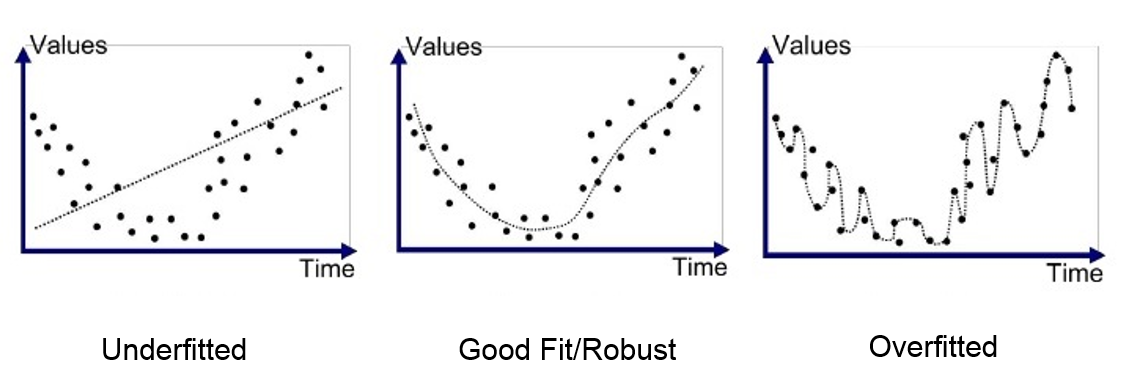

# 3. What cleansings steps did you need to take, if any?

I created a missing value table function that displayed the percent of each column in terms of NaN's, 

although every row was filled so, it proved to be an appropriate dataset. 

# 4. If you were working with a team of developers how would you hand off 

## your current code to them to apply in production?

I would save my model using joblib dump. If the developers were using Spark, I could run the model in PySpark that would 

directly draw the data in from a SQL data source. Another resource to use would be GitHub, where the code could be 

complied/saved by breaking up the code into smaller pieces, grouping functions, version control, commenting code, 

and reviewing it, before handing it off to be implemented in production and automation 

# 5. What are some downsides to not knowing what the variables mean, 

## what are some upside?

Some downsides to not knowing what the variables mean is not having a general familiarity of them, which could give you 

a better intrepetable result (i.e., coefficent of var_29 at .70 would not have the same affect as saying a 1 unit
                             
increase in year of age results in a 70% increase in target or a 70% of a target can be attributed to an increase
                             
or decrease in age). An upside is that the bias of the variables would be lost, as in it could be more

influential to use/keep a certain variable because you think it's important when in fact it's not.

# 6. Did you review any code from the Kaggle competition that influenced 

## your current approach and code? If so, please provide any discussion you reviews and

### how it influenced your approach. FYI this is not a trick question, we fully expect you to

#### take advantage of the work done before you.

https://www.kaggle.com/deepak525/best-parameters-lb-0-900

Most of the Kaggle competition code was more of less the same, with differeing parameters for a LGB model.

My work was done more with looking at other algorithms to compare as well as upsampling to see if that

had an effect, while also incorparting my own best parameters grid search.